### Data Understanding

In [527]:
import plotly
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

%matplotlib inline

sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticksplt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

Helper function that takes in the name of the table, and return a dataframe with the data

In [528]:
def read_csv(filename: str):
    return pd.read_csv("dados/pre-processed/" + filename + ".csv", sep=",")

Helper function that takes in a table and checks how many account ids are repeated

In [529]:
def check_repeated(df: pd.DataFrame, table_name: str):
    count = df['account_id'].value_counts().values
    repeated = [i for i in count if i >= 2]
    print("Number of repeated account id values in " + table_name + ": " + str(len(repeated)))

In [530]:
loans = read_csv("loan_dev")

### Loans

Start by reading the csv to a dataframe. Display first rows to assess the kind of data we're working with

In [531]:
loans = read_csv("loan_dev")
loans.head()

,loan_id,account_id,amount,duration,payments,status,loan_year,loan_month,loan_day,loan_date
0,4959,2,80952,24,3373,1,1994,1,5,1994-01-05
1,4961,19,30276,12,2523,-1,1996,4,29,1996-04-29
2,4973,67,165960,24,6915,1,1996,5,2,1996-05-02
3,4996,132,88440,12,7370,1,1996,11,6,1996-11-06
4,5002,173,104808,12,8734,1,1994,5,31,1994-05-31


In [532]:
loans["status"].replace([1, -1], ["Paid", "Not Paid"], inplace=True)

In [533]:
## Plot loans["status"] values as a pie chart
fig = px.pie(loans, values=loans["status"].value_counts().values, names=loans["status"].value_counts().index, title="Loan Status")

## Save it as jpg

## Make text more readeable
## Remove legend
fig.update_traces(textposition='outside', textinfo='percent+label', showlegend=False)
fig.write_image("plots/loans_status.png")
fig.show()

In [534]:
## Replace paid and not paid with 1 and -1
loans["status"].replace(["Paid", "Not Paid"], [1, -1], inplace=True)

Let's check for repeated rows. There can be two loans per account, however, there should not be any rows with the same loan_id

In [535]:
duplicated_loan = loans.loan_id.duplicated().any() if loans.loan_id.duplicated().any() else 0
loans_per_acc   = loans.account_id.duplicated().any() if loans.account_id.duplicated().any() else 0

print ("There are", duplicated_loan, "duplicated loans")
print ("Number of account with more than one loan:", loans_per_acc)

There are 0 duplicated loans
Number of account with more than one loan: 0


#### Heatmap

Find correlation between attributes using a heatmap

<AxesSubplot:>

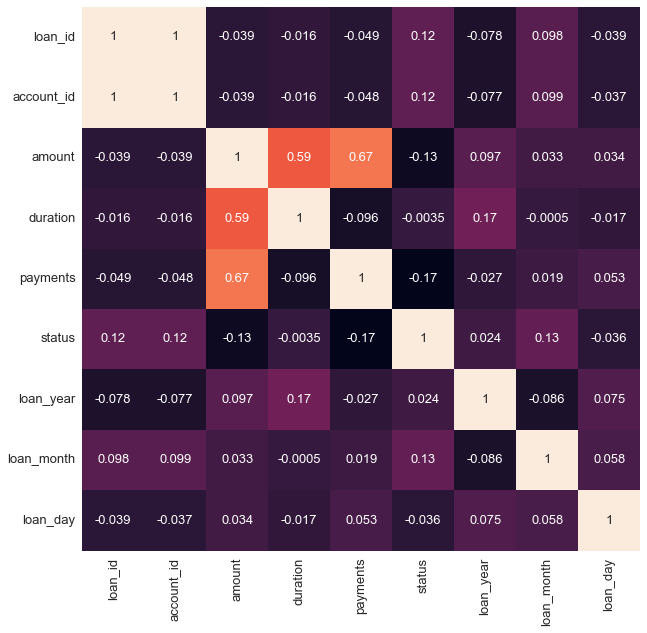

In [536]:
plt.figure(figsize=(10, 10))
sns.heatmap(loans.corr(), annot=True, cbar=False)

Status is inversely proportional to payments and amount, which is also expected, as the bigger the loan, the harder it is to pay it.
As per observation of the heatmap above, we see that payments, duration and amount of loan are correlated, as per expected.

#### Variable distribution

So let's analyse the distribution of values for amount and payments with two histograms.

In [537]:
## Loan duration from months to years
loans["duration"] = loans["duration"] / 12

In [538]:
## Unique values of duration
loans["duration"].unique()

array([2., 1., 4., 5., 3.])

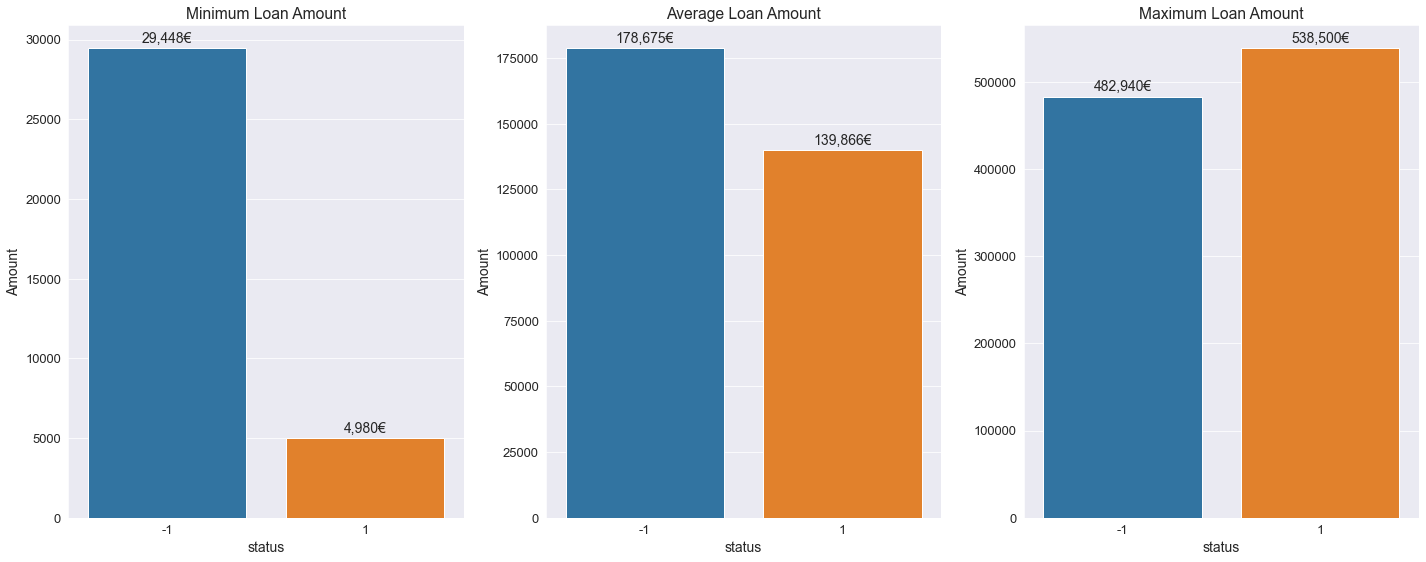

In [539]:
### Minumum, average and maximum loan amount per loan status
loans.groupby("status")["amount"].agg(["min", "mean", "max"])

## To df
loans_amount = loans.groupby("status")["amount"].agg(["min", "mean", "max"]).reset_index()

## Round float to 2 decimal places
loans_amount["mean"] = loans_amount["mean"].round(2)

## Per each column, plot the correspondent status, and plot them together
fig, ax = plt.subplots(1, 3, figsize=(20, 8))
sns.barplot(x="status", y="min", data=loans_amount, ax=ax[0])
sns.barplot(x="status", y="mean", data=loans_amount, ax=ax[1])
sns.barplot(x="status", y="max", data=loans_amount, ax=ax[2])

## Display values inside each bar
for i in range(3):
    for p in ax[i].patches:
        ## Display the value in the top of each bar with the € symbol and comma at thousands and no cents make text bigger
        ## append euro symbol to the value
        ax[i].annotate(format(p.get_height(), ',.0f') + "€", (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize=14)

## Increse vertical spacing to top
plt.subplots_adjust(top=0.9)

## Set y label
ax[0].set_ylabel("Amount")
ax[1].set_ylabel("Amount")
ax[2].set_ylabel("Amount")

## SET TITLE
ax[0].set_title("Minimum Loan Amount")
ax[1].set_title("Average Loan Amount")
ax[2].set_title("Maximum Loan Amount")

## Plot it with a better layout
fig.tight_layout()

## Save the image
plt.savefig("plots/loans_amount.png")


### Dispostion

In [540]:
disp = read_csv("disp")
disp.head()

,disp_id,client_id,account_id,type
0,1,1,1,owner
1,2,2,2,owner
2,3,3,2,disponent
3,4,4,3,owner
4,5,5,3,disponent


As per the discription of the table, the tuple (client_id, disp_id) should be unique. However, one account might have one or more client_ids

We will check for repetead values in all columns mentionted above

In [541]:
print("Duplicates in disp_id:\t\t%d" %disp['disp_id'].duplicated().any())
print("Duplicates in client_id:\t%d" %disp['client_id'].duplicated().any())
check_repeated(disp, "dispostion")

owner = disp['type'].str.count("owner")
print("Owner:   ", owner.sum())
print("Disponent:", owner.count() - owner.sum())


Duplicates in disp_id:		0
Duplicates in client_id:	0
Number of repeated account id values in dispostion: 869
Owner:    4500
Disponent: 869


There are no repeated client_id or account_id so there's no issues yet. The rest makes sense as there are 869 clients who are the disponent of an account and, there are exactly 869 repeated account ids

#### Heatmap

Let's merge dispostion and loan so that we can better assess correlation between varibales 

In [542]:
loans_ = loans[['account_id', 'status']]
loans_disp= loans_.merge(right=disp, how='inner', on='account_id')
print(loans_disp.head())

   account_id  status  disp_id  client_id       type
0           2       1        2          2      owner
1           2       1        3          3  disponent
2          19      -1       25         25      owner
3          67       1       78         78      owner
4         132       1      158        158      owner


To use the type in the heatmap, we need to convert it to a numerical value

In [543]:
loans_disp["type"].replace(["owner", "disponent"], [0, 1], inplace =True)
print(loans_disp.tail())

     account_id  status  disp_id  client_id  type
398       11265       1    13537      13845     0
399       11349       1    13647      13955     0
400       11349       1    13648      13956     1
401       11359       1    13660      13968     0
402       11362       1    13663      13971     0


<AxesSubplot:>

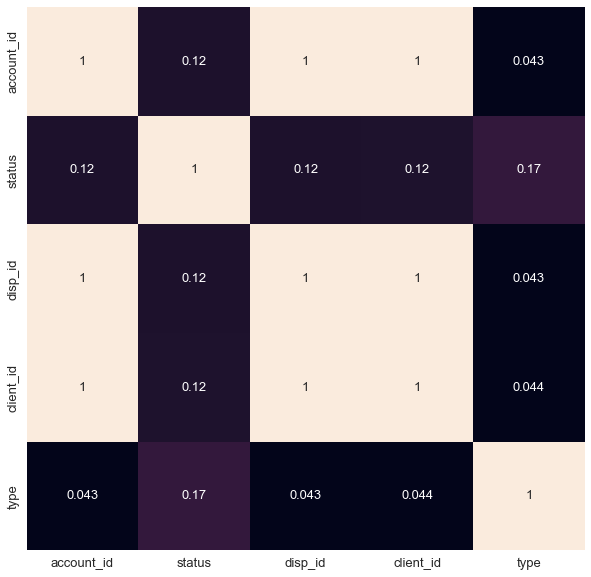

In [544]:
plt.figure(figsize=(10, 10))
sns.heatmap(loans_disp.corr(), annot=True, cbar=False)

### Account

In [545]:
accounts = read_csv('account')
accounts.head()

,account_id,district_id,frequency,acc_creation_year,acc_creation_month,acc_creation_day,acc_creation_date
0,1,18,monthly issuance,1995,3,24,1995-03-24
1,2,1,monthly issuance,1993,2,26,1993-02-26
2,3,5,monthly issuance,1997,7,7,1997-07-07
3,4,12,monthly issuance,1996,2,21,1996-02-21
4,5,15,monthly issuance,1997,5,30,1997-05-30


Merge with the loans dataset

In [546]:
loan_accounts = pd.merge(loans, accounts, how="left", on=["account_id"])
loan_accounts.head()

,loan_id,account_id,amount,duration,payments,status,loan_year,loan_month,loan_day,loan_date,district_id,frequency,acc_creation_year,acc_creation_month,acc_creation_day,acc_creation_date
0,4959,2,80952,2.0,3373,1,1994,1,5,1994-01-05,1,monthly issuance,1993,2,26,1993-02-26
1,4961,19,30276,1.0,2523,-1,1996,4,29,1996-04-29,21,monthly issuance,1995,4,7,1995-04-07
2,4973,67,165960,2.0,6915,1,1996,5,2,1996-05-02,16,monthly issuance,1994,10,19,1994-10-19
3,4996,132,88440,1.0,7370,1,1996,11,6,1996-11-06,40,issuance after transaction,1996,5,11,1996-05-11
4,5002,173,104808,1.0,8734,1,1994,5,31,1994-05-31,66,monthly issuance,1993,11,26,1993-11-26


We can also create new variables to better visualise the data, as the account age that is the subtraction of the year of the loan and the year of the creation of the account

In [547]:
loan_accounts["acc_age"] = loan_accounts.loan_year - loan_accounts.acc_creation_year

#### Heatmap

<AxesSubplot:>

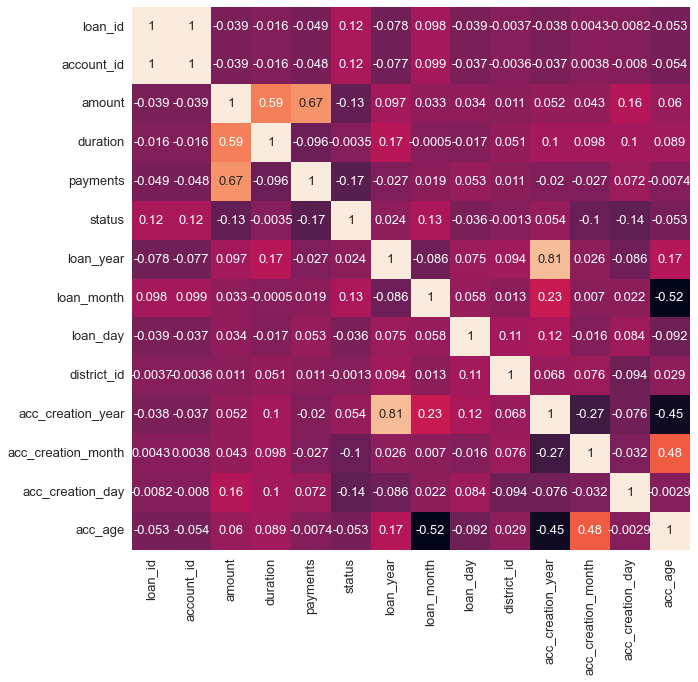

In [548]:
plt.figure(figsize=(10, 10))
sns.heatmap(loan_accounts.corr(), annot=True, cbar=False)

We can observe a correlation between acc_creation_year and loan_year, let's dive further

<AxesSubplot:xlabel='acc_age', ylabel='Count'>

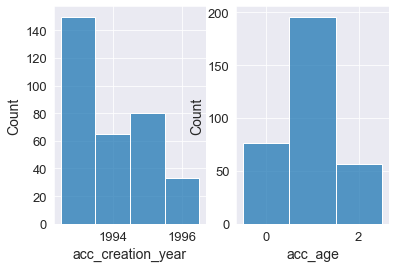

In [549]:
fig, ax = plt.subplots(1,2)

# Create the graphics
sns.histplot(data=loan_accounts, x='acc_creation_year', discrete=True, ax=ax[0])
sns.histplot(data=loan_accounts, x='acc_age', discrete=True, ax=ax[1])

### Card

In [550]:
cards = read_csv('card_dev')
cards_comp = read_csv('card_comp')
cards.tail()

,card_id,disp_id,type,card_issued_year,card_issued_month,card_issued_day,card_issued_date
172,1164,12269,classic,1996,8,12,1996-08-12
173,1176,12502,gold,1996,7,3,1996-07-03
174,1187,12635,gold,1996,7,17,1996-07-17
175,1225,13268,classic,1995,11,22,1995-11-22
176,1247,13660,classic,1995,6,13,1995-06-13


In [551]:
concat = pd.concat([cards, cards_comp])

In [552]:
## Number of rows after concatenating
print("Number of rows after concatenating: ", concat.shape[0])

Number of rows after concatenating:  202


Merge card table with dispotion and loan to check for variable correlation

In [553]:
## Read disposition
disps = read_csv('disp')

## Merge disposition and cards
cards_disp = pd.merge(concat, disps, how="left", on=["disp_id"])
cards_disp.head()

## Drop rows with duplicate account id
cards_disp.drop_duplicates(subset=['account_id'], inplace=True)

## Join with loan
loan_cards = pd.merge(cards_disp, loans, how="left", on=["account_id"])

In [554]:
### Get rows where loan id is not null
loan_cards = loan_cards[loan_cards["loan_id"].notnull()]
loan_cards.head()

,card_id,disp_id,type_x,card_issued_year,card_issued_month,card_issued_day,card_issued_date,client_id,account_id,type_y,loan_id,amount,duration,payments,status,loan_year,loan_month,loan_day,loan_date
30,119,655,classic,1996,8,8,1996-08-08,655,544,owner,5088.0,91152.0,2.0,3798.0,1.0,1996.0,8.0,22.0,1996-08-22
74,337,2141,classic,1996,1,1,1996-01-01,2141,1766,owner,5311.0,30060.0,5.0,501.0,1.0,1996.0,6.0,15.0,1996-06-15
120,577,3687,classic,1994,2,15,1994-02-15,3687,3050,owner,5595.0,82896.0,1.0,6908.0,1.0,1994.0,9.0,2.0,1994-09-02
164,783,5433,junior,1995,10,24,1995-10-24,5433,4503,owner,5900.0,135360.0,4.0,2820.0,1.0,1996.0,1.0,1.0,1996-01-01
168,989,9119,classic,1996,2,21,1996-02-21,9427,7614,owner,6550.0,320592.0,4.0,6679.0,1.0,1996.0,5.0,18.0,1996-05-18


#### Heatmap

<AxesSubplot:>

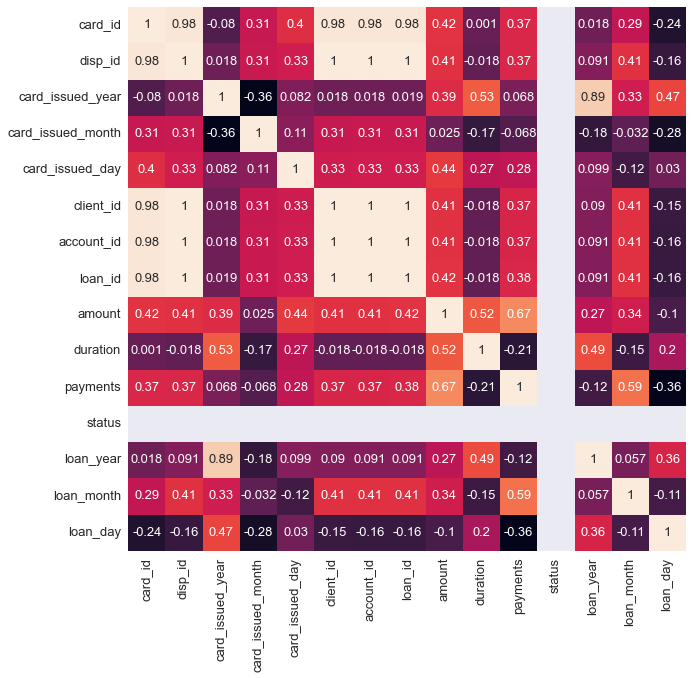

In [555]:
plt.figure(figsize=(10, 10))
sns.heatmap(loan_cards.corr(), annot=True, cbar=False)

### Client

In [556]:
def check_invalid_year(years: list):
    valid = range(1900, 2000)
    invalid = 0
    for year in years:
        if year not in valid:
            invalid = invalid + 1
    
    return invalid

In [557]:
def check_invalid_month(months: list):
    valid = range(1, 13)
    invalid = 0
    for month in months:
        if month not in valid:
            invalid = invalid + 1
    
    return invalid

In [558]:
def check_invalid_day(days: list):
    valid = range(1, 32)
    invalid = 0
    for day in days:
        if day not in valid:
            invalid = invalid + 1
    
    return invalid

In [559]:
client = read_csv("client")
client.tail()

,client_id,district_id,birthdate_year,birthdate_month,birthdate_day,birthdate,sex
5364,13955,1,1945,10,30,1945-10-30,f
5365,13956,1,1943,4,6,1943-04-06,m
5366,13968,61,1968,4,13,1968-04-13,m
5367,13971,67,1962,10,19,1962-10-19,f
5368,13998,74,1953,8,12,1953-8-12,f


Check for invalid dates

In [560]:
invalid_years = check_invalid_year(list(client.birthdate_year))
print("Invalid years -> ", invalid_years)

invalid_months = check_invalid_month(list(client.birthdate_month))
print("Invalid months -> ", invalid_months)

invalid_days = check_invalid_day(list(client.birthdate_day))
print("Invalid days -> ", invalid_days)


Invalid years ->  0
Invalid months ->  0
Invalid days ->  0


Let's check for gender inbalance

In [561]:
print(client.sex.value_counts())

m    2724
f    2645
Name: sex, dtype: int64


Looks pretty balanced, nothing to worry about

Let's now merge the client table with the loan table

In [562]:
client_loan = disp.merge(right = loans, how = "inner", on="account_id")
client_loan.head()

,disp_id,client_id,account_id,type,loan_id,amount,duration,payments,status,loan_year,loan_month,loan_day,loan_date
0,2,2,2,owner,4959,80952,2.0,3373,1,1994,1,5,1994-01-05
1,3,3,2,disponent,4959,80952,2.0,3373,1,1994,1,5,1994-01-05
2,25,25,19,owner,4961,30276,1.0,2523,-1,1996,4,29,1996-04-29
3,78,78,67,owner,4973,165960,2.0,6915,1,1996,5,2,1996-05-02
4,158,158,132,owner,4996,88440,1.0,7370,1,1996,11,6,1996-11-06


In [563]:
check_repeated(client_loan, "loan merged with client")

Number of repeated account id values in loan merged with client: 75


There are 75 loans that have been taken by accounts that are used by 2 clients

#### Could people that share an account have be a better chance at paying the loan since their household income would possibly be higher that those that are alone in an account?

In [564]:
## Get repeated loan ids
repeated = client_loan.groupby("loan_id").count()['disp_id'].sort_index()

## Export it to a dataframe
repeated_df = pd.DataFrame({"loan_id": repeated.index, "count": repeated.values})

## Get the status of the loans
status = client_loan[['loan_id', 'status']]

## Merge with the repeated dataframe using a inner join on loan_id
count_clients = repeated_df.merge(right=status, on="loan_id", how="inner")

## Remove duplicated values
count_clients.drop_duplicates(subset=['loan_id'])

,loan_id,count,status
0,4959,2,1
2,4961,1,-1
3,4973,1,1
4,4996,2,1
6,5002,2,1
...,...,...,...
396,7271,2,1
398,7284,1,1
399,7304,2,1
401,7305,1,1


In [565]:
## Rename the column count to # of clients
count_clients.rename(columns={"count": "# of clients"}, inplace=True)

## Replace status 1 and -1 with Paid and Not Paid
count_clients["status"].replace([1, -1], ["Paid", "Not Paid"], inplace=True)

## Pie chart, loan status and # of clients when the number is 1
fig = px.pie(count_clients[count_clients["# of clients"] == 1], values="# of clients", names="status", title="Loan Status of single accounts")
## No legend
fig.update_layout(showlegend=False)
## Make text more readeable
fig.update_traces(textposition='outside', textinfo='percent+label')
## Save to png
fig.write_image("plots/loan_status_single_accounts.png")
fig.show()

In [566]:
## Pie chart, loan status and # of clients when the number is 1
fig = px.pie(count_clients[count_clients["# of clients"] == 2], values="# of clients", names="status", title="Loan Status of shared accounts")
## Make text more readeable
fig.update_traces(textposition='inside', textinfo='percent+label')
## Save to png
## No legend
fig.update_layout(showlegend=False)
fig.write_image("plots/loan_status_shared_accounts.png")
fig.show()

Check for correlation

In [567]:
#Replace the values again
count_clients["status"].replace(["Paid", "Not Paid"], [1, -1], inplace=True)

count_clients[["# of clients", "status"]].corr()

,# of clients,status
# of clients,1.000000,0.276395
status,0.276395,1.000000


#### Check for correlation in gender and age

Firstly, let's convert categorical sex value to numerical

In [568]:
client.replace(["m", "f"], [0, 1], inplace=True)
client.tail()

,client_id,district_id,birthdate_year,birthdate_month,birthdate_day,birthdate,sex
5364,13955,1,1945,10,30,1945-10-30,1
5365,13956,1,1943,4,6,1943-04-06,0
5366,13968,61,1968,4,13,1968-04-13,0
5367,13971,67,1962,10,19,1962-10-19,1
5368,13998,74,1953,8,12,1953-8-12,1


In [569]:
client_loan_2 = disp.merge(right = loans, how = "inner", on="account_id")
client_loan_2 = client_loan_2[['account_id', 'client_id', 'status']]
client_2 = client[['client_id', 'birthdate_year', 'sex']]
client_2

,client_id,birthdate_year,sex
0,1,1970,1
1,2,1945,0
2,3,1940,1
3,4,1956,0
4,5,1960,1
...,...,...,...
5364,13955,1945,1
5365,13956,1943,0
5366,13968,1968,0
5367,13971,1962,1


In [570]:
association = client_2.merge(right=client_loan_2, on="client_id", how="inner")
association = association[["birthdate_year", "sex", "status"]]

<AxesSubplot:>

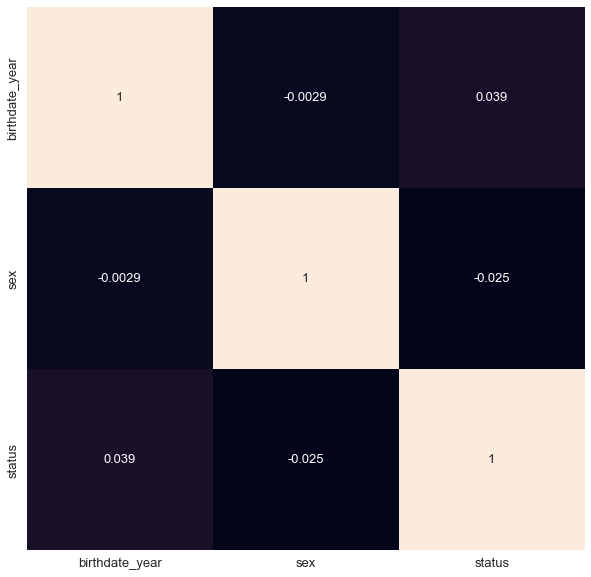

In [571]:
plt.figure(figsize=(10, 10))
sns.heatmap(association.corr(), annot=True, cbar=False)

### District

In [572]:
districts = read_csv('district')

Let's visualize correlations between attributtes using a heatmap

#### Heatmap

<AxesSubplot:>

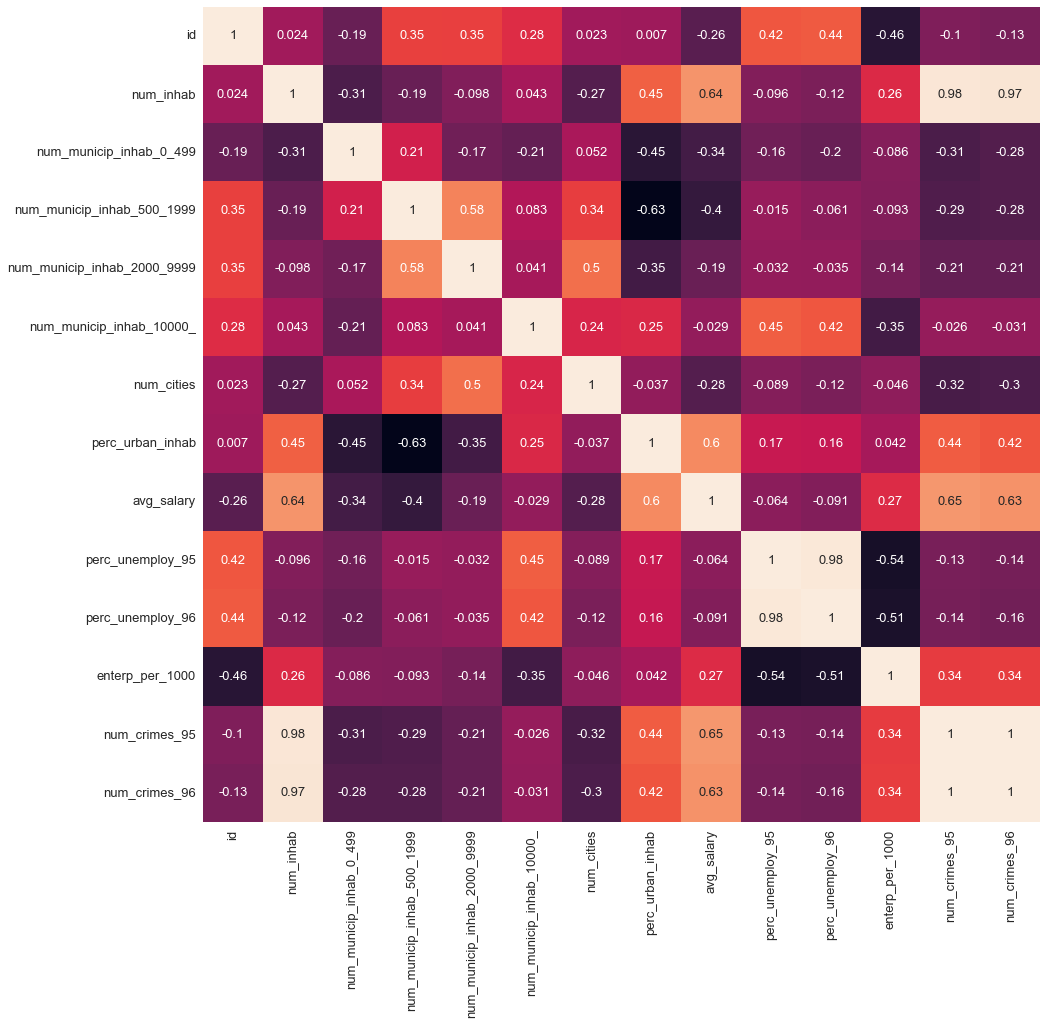

In [573]:
plt.figure(figsize=(15, 15))
sns.heatmap(districts.corr(), annot=True, cbar=False)

Some interesting but rather expected findings:
-   The higher the percentage of urban population, the higher the average salary
-   The higher the unemployment rate in any of the years, the lower the number of enterpreneurs per 100 people

Other correlations might be due to the fact that the data is not standardized

Let's plot some variables

<AxesSubplot:xlabel='num_inhab', ylabel='Count'>

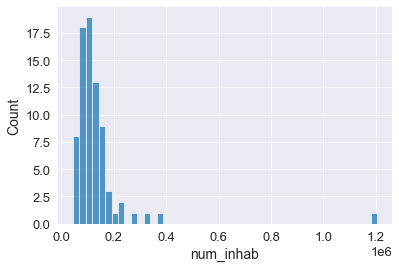

In [574]:
fig = plt.plot()
sns.histplot(data=districts, x='num_inhab')

There's a region whose number of habitatnts is way above the rest.
Let's see if we're dealing with an outlier

In [575]:
districts[districts["num_inhab"] > 1000000]

,id,city,region,num_inhab,num_municip_inhab_0_499,num_municip_inhab_500_1999,num_municip_inhab_2000_9999,num_municip_inhab_10000_,num_cities,perc_urban_inhab,avg_salary,perc_unemploy_95,perc_unemploy_96,enterp_per_1000,num_crimes_95,num_crimes_96,region_zone
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677.0,99107,NaN


A simple google search can atest the verocity of the population value. Not an outlier

<AxesSubplot:xlabel='num_crimes_95', ylabel='Count'>

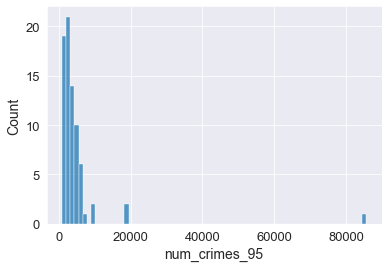

In [576]:
fig = plt.plot()
sns.histplot(data=districts, x='num_crimes_95')

Don't need to check if that's an outlier, it's just Prague. 

<AxesSubplot:xlabel='num_crimes_96', ylabel='Count'>

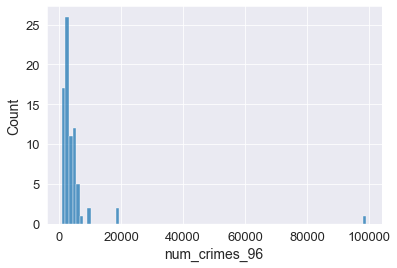

In [577]:
fig = plt.plot()
sns.histplot(data=districts, x='num_crimes_96')

Same here

#### Unemployment rate & Crimes

Let's do some exploratory analysis of this columns as they're some of the most important columns when deciding who to give a loan to (more the unemployment that crimes)

Check if there was an increase in unemployment in the two years in the dataset

In [578]:
crimes_95_mean = districts['num_crimes_95'].mean()
crimes_96_mean = districts['num_crimes_96'].mean()

unemployment_95_mean = districts['perc_unemploy_95'].mean()
unemployment_96_mean = districts['perc_unemploy_96'].mean()

print("\t1995")
print("Crimes: ", crimes_95_mean)
print("Unemployment: ", unemployment_95_mean)

print("\t1996")
print("Crimes: ", crimes_96_mean)
print("Unemployment: ", unemployment_96_mean)

print("\n")

print(f"Crime percentage increase: {round((crimes_96_mean - crimes_95_mean)/crimes_95_mean*100, 2)}%")
print(f"Unemploymnet percentage increase: {round(unemployment_96_mean - unemployment_95_mean,2)}%")

	1995
Crimes:  4850.315789473684
Unemployment:  3.119342105263158
	1996
Crimes:  5030.831168831169
Unemployment:  3.787012987012987


Crime percentage increase: 3.72%
Unemploymnet percentage increase: 0.67%


Let's now take a look into the regions

In [579]:
districts["region"].unique()

array(['Prague', 'Bohemia', 'Moravia'], dtype=object)

Only three regions in the dataset, let's take a look into each one

In [580]:
prague = districts[districts['region'] == 'Prague']
bohemia = districts[districts['region'] == 'Bohemia']
moravia = districts[districts['region'] == 'Moravia']

Compare salaries in all

In [581]:
print(f"Average salary in Prague:  {round(prague['avg_salary'].mean(), 2)}€")
print(f"Average salary in Bohemia: {round(bohemia['avg_salary'].mean(), 2)}€")
print(f"Average salary in Moravia: {round(moravia['avg_salary'].mean(), 2)}€")

Average salary in Prague:  12541.0€
Average salary in Bohemia: 9042.31€
Average salary in Moravia: 8869.6€


Prague is the richest region, which is to be expected since it's the capital of the country

#### Prague

In [582]:
print(f"Crimes per inhab: {prague['num_crimes_96'].mean() / prague['num_inhab'].mean()}") 
print(f"Unemployment rate: {prague['perc_unemploy_96'].mean()}")
print(f"Percentage of people living in urban areas: {prague['perc_urban_inhab'].mean()}")
print(f"Number of enterpreneurs per 1000 people: {prague['enterp_per_1000'].mean()}")

print(f"Number of entries for Prague: {len(prague)}")

Crimes per inhab: 0.08224968110789384
Unemployment rate: 0.43
Percentage of people living in urban areas: 100.0
Number of enterpreneurs per 1000 people: 167.0
Number of entries for Prague: 1


Prague only has one entrie in the whole dataset, we will count it as an outlier

#### Bohemia

In [583]:
print(f"Crimes per inhab: {bohemia['num_crimes_96'].mean() / bohemia['num_inhab'].mean()}") 
print(f"Unemployment rate: {bohemia['perc_unemploy_96'].mean()}")
print(f"Percentage of people living in urban areas: {bohemia['perc_urban_inhab'].mean()}")
print(f"Number of enterpreneurs per 1000 people: {bohemia['enterp_per_1000'].mean()}")

print(f"Number of entries for Bohemia: {len(bohemia)}")

Crimes per inhab: 0.03278450638751398
Unemployment rate: 3.4294117647058826
Percentage of people living in urban areas: 64.09803921568627
Number of enterpreneurs per 1000 people: 118.76470588235294
Number of entries for Bohemia: 51


Let's now check differences within zones in a region.

In [584]:
direction = bohemia['region_zone'].unique()
for i in direction:
    region_direction = bohemia[bohemia['region_zone'] == i]
    print(f"Direction: {i} -> {region_direction['avg_salary'].mean()}€")

Direction: central -> 9357.25€
Direction: south -> 8831.5€
Direction: west -> 9015.4€
Direction: north -> 9334.2€
Direction: east -> 8611.181818181818€


#### Moravia

In [585]:
print(f"Crimes per inhab: {moravia['num_crimes_96'].mean() / moravia['num_inhab'].mean()}") 
print(f"Unemployment rate: {moravia['perc_unemploy_96'].mean()}")
print(f"Percentage of people living in urban areas: {moravia['perc_urban_inhab'].mean()}")
print(f"Number of enterpreneurs per 1000 people: {moravia['enterp_per_1000'].mean()}")

print(f"Number of entries for Moravia: {len(moravia)}")

Crimes per inhab: 0.030248247890649393
Unemployment rate: 4.6508
Percentage of people living in urban areas: 59.388000000000005
Number of enterpreneurs per 1000 people: 108.72
Number of entries for Moravia: 25


Let's now check differences within zones in a region.

In [586]:
direction = moravia['region_zone'].unique()
for i in direction:
    region_direction = moravia[moravia['region_zone'] == i]
    print(f"Direction: {i} -> {region_direction['avg_salary'].mean()}€")

Direction: south -> 8728.5€
Direction: north -> 9049.181818181818€


Bohemia has a lower unemployment rate than moravia, has more enterpreneurs per 100 people and more people living in urban areas.

In both regions, the northern part is richer that their southern counterpart.
For Bohemia, the worst zone to live would be east, while the best would be either north or cental

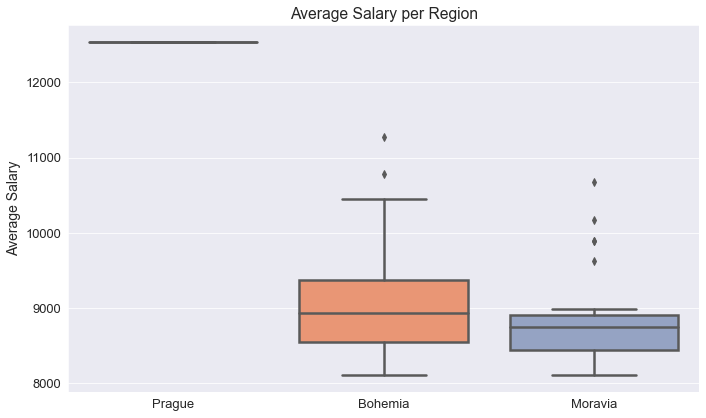

In [587]:
## Boxplot with average salary per region
plt.figure(figsize=(10,6), tight_layout=True)
ax = sns.boxplot(data=districts, x='region', y='avg_salary', palette='Set2', linewidth=2.5)
ax.set(title='Boxplot', xlabel='', ylabel='Average Salary')
plt.title("Average Salary per Region")
## Save as png
plt.savefig("plots/avg_salary_per_region.png")
plt.show()

### Transactions

In [588]:
trans = pd.read_csv("dados/pre-processed/trans_dev.csv", na_values=[' '])
trans.head()

C:\Users\veris\AppData\Local\Temp\ipykernel_16420\2667802477.py:1: DtypeWarning:

Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.



,trans_id,account_id,type,operation,amount,balance,k_symbol,bank,account,trans_year,trans_month,trans_day,trans_date
0,1,1,credit,cash,1000.0,1000.0,NaN,NaN,NaN,1995,3,24,1995-03-24
1,5,1,credit,another bank,3679.0,4679.0,NaN,AB,41403269.0,1995,4,13,1995-04-13
2,6,1,credit,another bank,3679.0,20977.2,NaN,AB,41403269.0,1995,5,13,1995-05-13
3,7,1,credit,another bank,3679.0,26835.2,NaN,AB,41403269.0,1995,6,13,1995-06-13
4,8,1,credit,another bank,3679.0,30414.8,NaN,AB,41403269.0,1995,7,13,1995-07-13


In [589]:
print(f"Number of recorded transactions: {len(trans)}")

Number of recorded transactions: 396685


Identify columns with null values

In [590]:
trans.isna().any()

trans_id       False
account_id     False
type           False
operation       True
amount         False
balance        False
k_symbol        True
bank            True
account         True
trans_year     False
trans_month    False
trans_day      False
trans_date     False
dtype: bool

As we can see, lots of columns have null values: operation, k_symbol, bank and account. We'll need to be careful in the way that we parse these null values. Let's start by analyzing each table

#### Account column

In [591]:
trans["account"].value_counts(dropna=False, normalize=True)

NaN           0.742292
0.0           0.012572
62457513.0    0.000121
73166322.0    0.000121
6149286.0     0.000121
                ...   
26197439.0    0.000003
6951642.0     0.000003
1385760.0     0.000003
18026441.0    0.000003
249672.0      0.000003
Name: account, Length: 4537, dtype: float64

In [592]:
print("Number of transactions with missing account:", trans['account'].isna().sum())

Number of transactions with missing account: 294456


Let's check the number of transactions per year. This is important, as it might show how active a client is

In [593]:
## Group transactions by account id and year
trans_per_year = trans.groupby(by=['account_id', 'trans_year'], axis=0, as_index=False).size()

## Count the number of years in which an account made a transaction
account_years = trans_per_year['account_id'].value_counts()

## Get indexes and values
index_count_year = account_years.index 
values_count_year = account_years.values

## To pandas dataframe
df = pd.DataFrame({'account_id': index_count_year, 'count_year': values_count_year})

# Get the number of transaction per account id
trans_per_acc = trans.groupby(by=['account_id'], axis=0, as_index=False).size()

final = df.sort_values("account_id")
final['trans'] = trans_per_acc["size"]
final['trans_year'] = final['trans'] / final['count_year']
final.sort_values("trans_year", inplace=True, ascending=False)
final


,account_id,count_year,trans,trans_year
2164,840,1,441,441.00
2159,3904,1,402,402.00
2215,856,1,398,398.00
2893,2573,1,382,382.00
3362,1546,1,369,369.00
...,...,...,...,...
980,437,4,1,0.25
182,1966,4,1,0.25
130,730,4,1,0.25
491,3654,4,1,0.25


The most active account had 441 transaction per year, all within only one year.

#### Operation Column

In [594]:
count_operations = trans['operation'].value_counts(dropna=False)
count_operations

cash            227472
another bank     97242
NaN              70761
credit card       1210
Name: operation, dtype: int64

<AxesSubplot:>

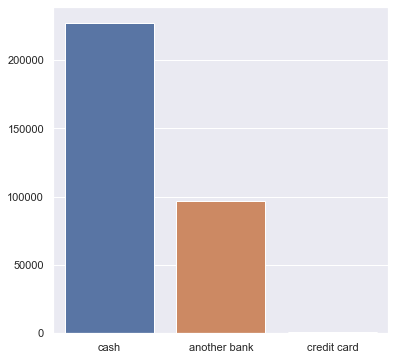

In [595]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(6, 6)})

x = count_operations.index.tolist()
y = count_operations.values.tolist()

sns.barplot(x=x, y=y)

In [596]:
print(f"Number of transactions with null operation: {trans.operation.isna().sum()}")

Number of transactions with null operation: 70761


Lots of transactions missing the operation value...

#### K-symbol

In [597]:
types_ksymbol = trans["k_symbol"].unique()
types_ksymbol

array([nan, 'household', 'payment for statement', 'old-age pension',
       'insurrance payment', 'interest credited',
       'sanction interest if negative balance'], dtype=object)

In [598]:
count_ksymbol = trans["k_symbol"].value_counts(dropna=False, normalize=True)
count_ksymbol

NaN                                      0.515041
interest credited                        0.178381
payment for statement                    0.147162
household                                0.107992
old-age pension                          0.034037
insurrance payment                       0.016618
sanction interest if negative balance    0.000769
Name: k_symbol, dtype: float64

The number of NaN transactions is too high to be considered as not important.

<AxesSubplot:>

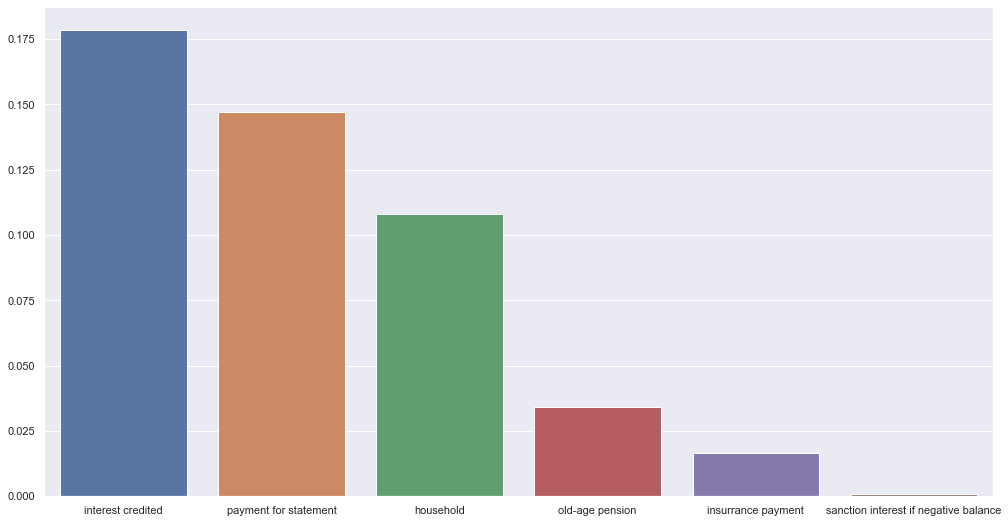

In [599]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(17, 9)})

x = count_ksymbol.index.tolist()
y = count_ksymbol.values.tolist()

sns.barplot(x=x, y=y)

#### Bank

In [600]:
types_bank = trans["bank"].unique()
types_bank

array([nan, 'AB', 'YZ', 'ST', 'QR', 'UV', 'OP', 'IJ', 'KL', 'EF', 'MN',
       'GH', 'CD', 'WX'], dtype=object)

In [601]:
trans["bank"].value_counts(dropna=False, normalize=True)

NaN    0.754863
ST     0.020455
GH     0.019880
EF     0.019860
AB     0.019325
UV     0.019204
OP     0.019146
IJ     0.018997
YZ     0.018834
QR     0.018687
KL     0.018647
WX     0.017729
CD     0.017669
MN     0.016703
Name: bank, dtype: float64

Once again, the number of NAN values might be too high to be discarded.

#### Others

**Years**

<AxesSubplot:>

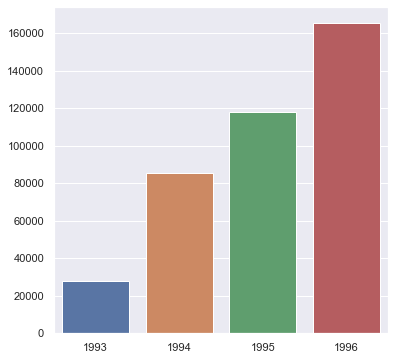

In [602]:
counts_year = trans['trans_year'].value_counts()
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(6, 6)})

x = counts_year.index.tolist()
y = counts_year.values.tolist()

sns.barplot(x=x, y=y)

Looks like an accurate distribution

**Months**

<AxesSubplot:>

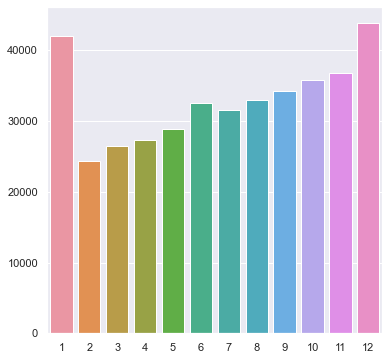

In [603]:
counts_months = trans['trans_month'].value_counts()
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(6, 6)})

x = counts_months.index.tolist()
y = counts_months.values.tolist()

sns.barplot(x=x, y=y)

More transactions in the months of January and December. Would assume these are the most commom months to pay the loan yearly installment

**Days**

<AxesSubplot:>

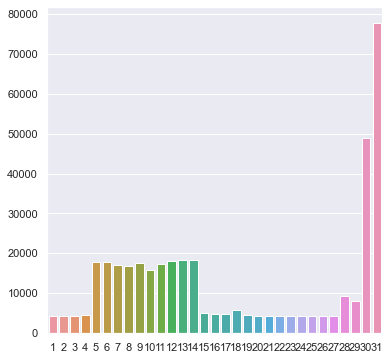

In [604]:
counts_days = trans['trans_day'].value_counts()
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(6, 6)})

x = counts_days.index.tolist()
y = counts_days.values.tolist()

sns.barplot(x=x, y=y)

Following the same logic, one would say that the last days of the month are the most commom to pay the loan installment

#### Balance 

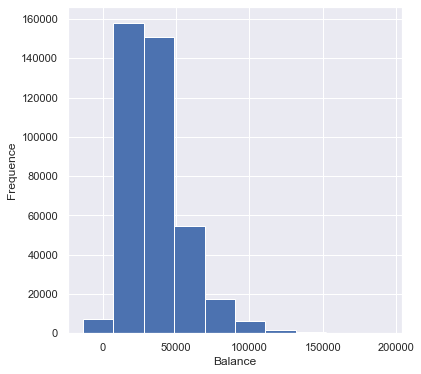

In [605]:
fig, ax = plt.subplots()
plt.hist(trans['balance'])
ax.set_xlabel("Balance")
ax.set_ylabel("Frequence")

plt.show()

In [606]:
average_balance = trans["balance"].mean()
print(f"The average balance after a transaction is {round(average_balance, 2)}€")

The average balance after a transaction is 35804.79€


#### Amount

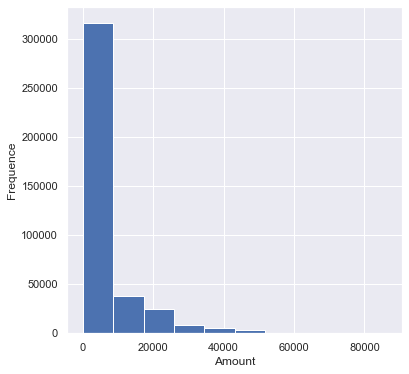

In [607]:
fig, ax = plt.subplots()
plt.hist(trans['amount'])
ax.set_xlabel("Amount")
ax.set_ylabel("Frequence")

plt.show()

In [608]:
average_trans_ammount = trans["amount"].mean()
print(f"The average amount of a transaction is {round(average_trans_ammount, 2)}€")

The average amount of a transaction is 5677.55€


#### Heatmap

<AxesSubplot:>

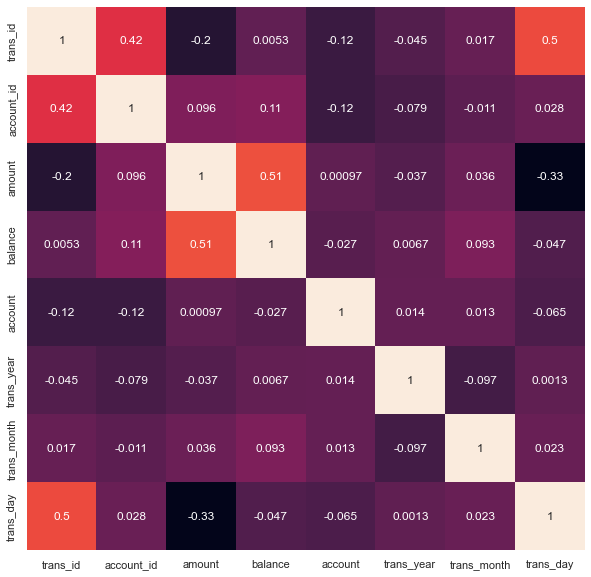

In [609]:
plt.figure(figsize=(10, 10))
sns.heatmap(trans.corr(), annot=True, cbar=False)

Obviously, there is correlation between the amount of a transaction and the balance after

Percentage of unpaid loan, by transaction type

In [610]:
transactions = read_csv("trans_dev")
loans        = read_csv("loan_dev")

## Replace na k_symbol with "none"
transactions["k_symbol"] = transactions["k_symbol"].fillna("none")

## Replace empty k_symbol with "Other"
transactions["k_symbol"] = transactions["k_symbol"].replace(" ", "Other")

## Create dataframe where the k symbol of transaction contains "sanction"
sanction = transactions[transactions["k_symbol"].str.contains("sanction")]

## Dataframe where k symbol contains "household"
household = transactions[transactions["k_symbol"].str.contains("household")]

## dataframe where k symbol contains "insurrance"
insurrance = transactions[transactions["k_symbol"].str.contains("insurrance")]

## Dataframe where k symbol contains interest
interest = transactions[transactions["k_symbol"].str.contains("interest")]

## DataFrame where k symbol contains "other
other = transactions[transactions["k_symbol"].str.contains("Other")]

## DataFrame where k symbol contains "interest"
interest = transactions[transactions["k_symbol"].str.contains("interest")]

## DataFrame where k symbol contains "pension"
pension = transactions[transactions["k_symbol"].str.contains("pension")]

## Create array with labels, uppercased
labels = ["Sanction", "Household", "Insurrance", "Interest", "Other"]
values = []

C:\Users\veris\AppData\Local\Temp\ipykernel_16420\2011332174.py:2: DtypeWarning:

Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.



In [611]:
pension

,trans_id,account_id,type,operation,amount,balance,k_symbol,bank,account,trans_year,trans_month,trans_day,trans_date
137,1020,4,credit,another bank,5553.0,6353.0,old-age pension,UV,89899795.0,1996,3,11,1996-03-11
138,1021,4,credit,another bank,5553.0,11906.0,old-age pension,UV,89899795.0,1996,4,11,1996-04-11
139,1022,4,credit,another bank,5553.0,17459.0,old-age pension,UV,89899795.0,1996,5,11,1996-05-11
140,1023,4,credit,another bank,5553.0,23012.0,old-age pension,UV,89899795.0,1996,6,11,1996-06-11
141,1024,4,credit,another bank,5553.0,28565.0,old-age pension,UV,89899795.0,1996,7,11,1996-07-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
319739,2908732,9635,credit,another bank,4470.0,11431.9,old-age pension,CD,37906074.0,1996,8,14,1996-08-14
319740,2908733,9635,credit,another bank,4470.0,12814.2,old-age pension,CD,37906074.0,1996,9,14,1996-09-14
319741,2908734,9635,credit,another bank,4470.0,12737.5,old-age pension,CD,37906074.0,1996,10,14,1996-10-14
319742,2908735,9635,credit,another bank,4470.0,14768.1,old-age pension,CD,37906074.0,1996,11,14,1996-11-14


In [612]:
## Megre sanction dataframe with loans dataframe
sanction = sanction.merge(loans, on="account_id", how="inner")

## Do the same for the other dataframes
household = household.merge(loans, on="account_id", how="inner")
insurrance = insurrance.merge(loans, on="account_id", how="inner")
interest = interest.merge(loans, on="account_id", how="inner")
other = other.merge(loans, on="account_id", how="inner")
pension = pension.merge(loans, on="account_id", how="inner")

In [613]:
## Percentage of loans which status is 1, at sanction dataframe
print(f"[Sanction] -> Percentage of paid loans: {round(len(sanction[sanction['status'] == 1]) / len(sanction) * 100, 2)}%")
values.append(round(len(sanction[sanction['status'] == 1]) / len(sanction) * 100, 2))

## Percentage of paid loans at household df
print(f"[Household] -> Percentage of paid loans: {round(len(household[household['status'] == 1]) / len(household) * 100, 2)}%")
values.append(round(len(household[household['status'] == 1]) / len(household) * 100, 2))

## Percentage of paid loans at insurrance df
print(f"[Insurrance] -> Percentage of paid loans: {round(len(insurrance[insurrance['status'] == 1]) / len(insurrance) * 100, 2)}%")
values.append(round(len(insurrance[insurrance['status'] == 1]) / len(insurrance) * 100, 2))

## Percentage of paid loans at interest df
print(f"[Interest] -> Percentage of paid loans: {round(len(interest[interest['status'] == 1]) / len(interest) * 100, 2)}%")
values.append(round(len(interest[interest['status'] == 1]) / len(interest) * 100, 2))

## Percentage of paid loans at other df
print(f"[Other] -> Percentage of paid loans: {round(len(other[other['status'] == 1]) / len(other) * 100, 2)}%")
values.append(round(len(other[other['status'] == 1]) / len(other) * 100, 2))

[Sanction] -> Percentage of paid loans: 31.58%
[Household] -> Percentage of paid loans: 92.23%
[Insurrance] -> Percentage of paid loans: 94.03%
[Interest] -> Percentage of paid loans: 85.58%
[Other] -> Percentage of paid loans: 93.81%


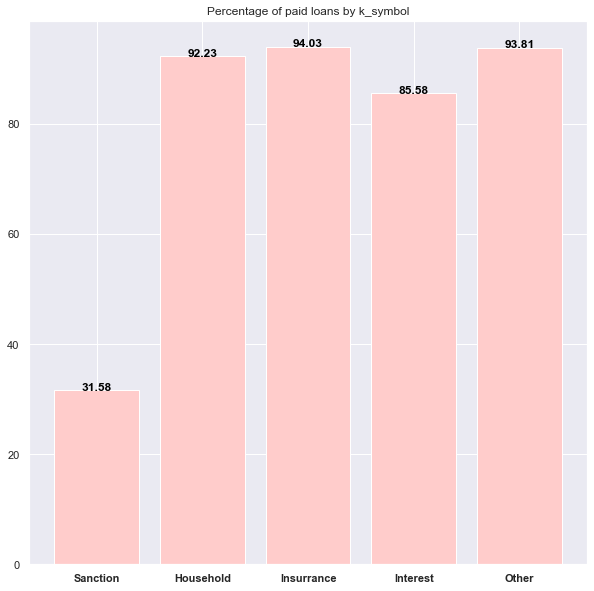

In [614]:
## Plot a bar chart with values and labels, y label is percentage of paid loans, 
plt.figure(figsize=(10, 10))
plt.title("Percentage of paid loans by k_symbol")
## Change color to light green
plt.bar(labels, values, color="#ffcccb")
## Make x axis bold
plt.xticks(fontweight="bold")
## Add the values to the plot
for i, v in enumerate(values):
    plt.text(i, v, str(v), color='black', fontweight='bold', horizontalalignment='center')
plt.savefig("plots/percentage_of_paid_loans_by_k_symbol.jpg")
plt.show()

In [615]:
## Create a dataframe with the amount of transactions per k_symbol per year
transactions_per_year = trans.groupby(["k_symbol", "trans_year"]).agg({"amount": "mean"}).reset_index()

## Remove decimal places
transactions_per_year["amount"] = transactions_per_year["amount"].astype(int)

## Replace insurrance paymente with insurrance
transactions_per_year["k_symbol"] = transactions_per_year["k_symbol"].replace("insurrance payment", "insurrance")

## Replcae old-age pension with just pension
transactions_per_year["k_symbol"] = transactions_per_year["k_symbol"].replace("old-age pension", "pension")

## Replace interest credited with interest
transactions_per_year["k_symbol"] = transactions_per_year["k_symbol"].replace("interest credited", "interest")

## Replace whetever contains sanction with just sanction
transactions_per_year["k_symbol"] = transactions_per_year["k_symbol"].replace("sanction interest if negative balance", "sanction")

## Replace payment stataement with stataement
transactions_per_year["k_symbol"] = transactions_per_year["k_symbol"].replace("payment for statement", "statement")

In [616]:
transactions_per_year

,k_symbol,trans_year,amount
0,household,1993,4348
1,household,1994,4068
2,household,1995,4024
3,household,1996,4025
4,insurrance,1993,1226
5,insurrance,1994,1302
6,insurrance,1995,1274
7,insurrance,1996,1177
8,interest,1993,133
9,interest,1994,140


In [617]:
## Create a df where the trans_year is the index and k_symbol is the columns and amount is the values, ignore index
transactions_per_year = transactions_per_year.pivot(index="trans_year", columns="k_symbol", values="amount")


In [618]:
transactions_per_year

k_symbol,household,insurrance,interest,pension,sanction,statement
trans_year,,,,,,
1993,4348,1226,133,5515,8,17
1994,4068,1302,140,5522,5,16
1995,4024,1274,142,5507,7,16
1996,4025,1177,141,5525,10,16


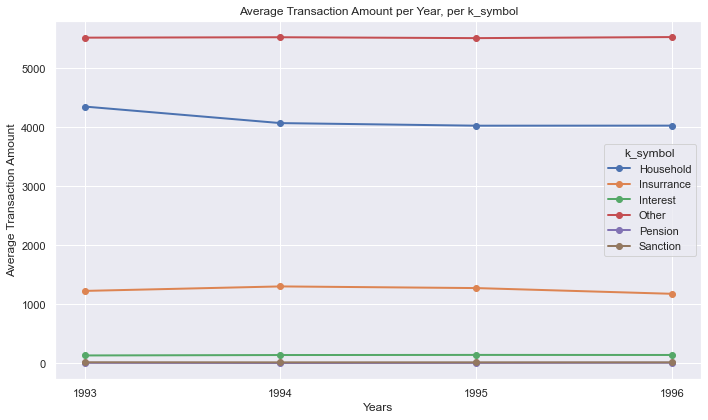

In [619]:
## Plot a line chart with the amount of transactions per year per k_symbol
plt.figure(figsize=(10,6), tight_layout=True)

plt.plot(transactions_per_year, 'o-', linewidth=2)
plt.xticks([1993, 1994, 1995, 1996])
plt.xlabel("Years")
plt.ylabel("Average Transaction Amount")
plt.title("Average Transaction Amount per Year, per k_symbol")
plt.legend(title="k_symbol", labels=["Household", "Insurrance", "Interest", "Other", "Pension", "Sanction", "Statement"])
plt.savefig("plots/average_transaction_amount_per_year_per_k_symbol.jpg")
plt.show()
